In [8]:
import os
import pandas as pd 
import math
import numpy as np 
import matplotlib.pyplot as plt
import random as r 
import preputil as util 
import glob
pd.options.mode.chained_assignment = None  # default='warn'

In [9]:
batchNum = 6
simfilepath = "/nBodyData/brutusSim/batch_brutus{0}*".format(batchNum)
alf = [i for i in glob.glob(simfilepath)]
if len(alf) < 1: print("Error: could not find sim files")
sdf = pd.concat([pd.read_csv(f,index_col=False) for f in alf],sort=False)

prediction = False
nnfile = "/nBodyData/pred/predicted_paths_batch_3_1.csv"
dataCols = ["x1tEnd_j", "x2tEnd_j", "x3tEnd_j", "y1tEnd_j", "y2tEnd_j", "y3tEnd_j","eventID"]
pdf = sdf
if prediction:
    pdf = pd.read_csv(nnfile, names=dataCols)

# combine dataframes
pdf.eventID = pdf.eventID.astype(int)
pdf.sort_values(["eventID"], axis=0, ascending=True, inplace= True) 
df = pdf
if prediction:
    adf = pd.merge(left=sdf,right=pdf, on='eventID')
    df = adf.drop_duplicates(subset='eventID')

In [8]:
########## MEAN SQUARED ERROR (IN COORDINATES) WONT WORK W/O NN DF
df["delta_solns"] = np.sqrt(((df['x1tEnd'] - df['x1tEnd_j'])**2) + ((df['x2tEnd'] - df['x2tEnd_j'])**2) + ((df['x3tEnd'] - df['x3tEnd_j'])**2) +((df['y1tEnd'] - df['y1tEnd_j'])**2) +((df['y2tEnd'] - df['y2tEnd_j'])**2) + ((df['y3tEnd'] - df['y3tEnd_j'])**2))
amse_x1 = []
amse_x2 = []
amse_x3 = []
amse_y1 = []
amse_y2 = []
amse_y3 = []

times = np.linspace(0, 10, num=2561)
for i,t in enumerate(times):
    df_t = df.loc[df['tEnd'] == times[i]]
    for j in range(1,4):
        df_t["mse_x{0}".format(j)] = np.sqrt((df_t['x{0}tEnd'.format(j)] - df_t['x{0}tEnd_j'.format(j)])**2)
        df_t["mse_y{0}".format(j)] = np.sqrt((df_t['y{0}tEnd'.format(j)] - df_t['y{0}tEnd_j'.format(j)])**2)
    
    amse_x1.append(df_t["mse_x1"].mean(axis=0))
    amse_x2.append(df_t["mse_x2"].mean(axis=0))
    amse_x3.append(df_t["mse_x3"].mean(axis=0))
    amse_y1.append(df_t["mse_y1"].mean(axis=0))
    amse_y2.append(df_t["mse_y2"].mean(axis=0))
    amse_y3.append(df_t["mse_y3"].mean(axis=0))

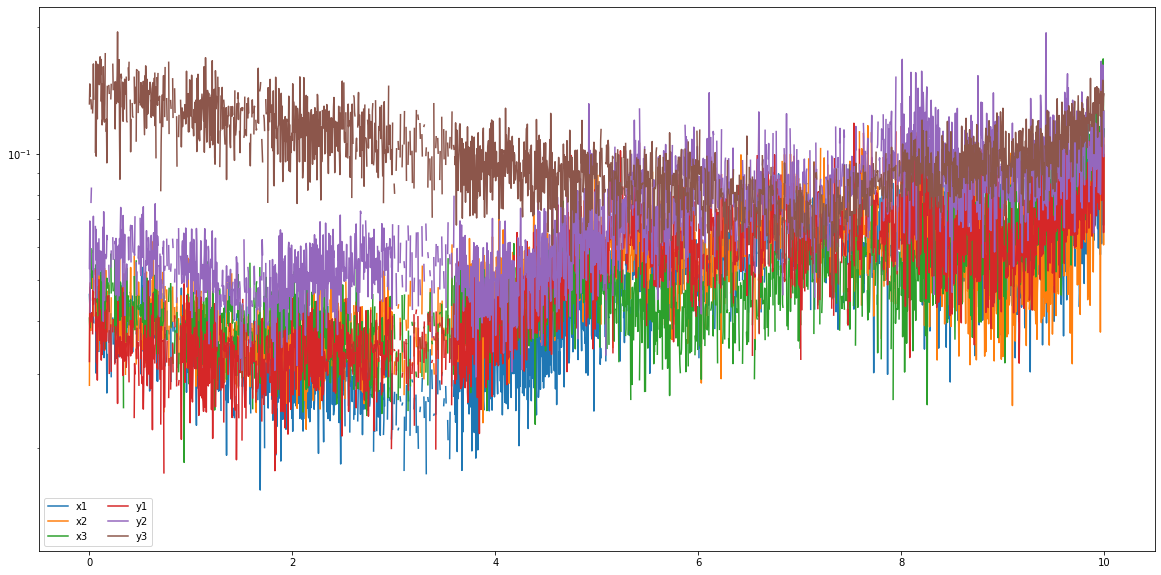

In [11]:
########### PLOT MEAN SQUARED ERROR 
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (20, 10)
ax.plot(times, amse_x1, label="x1")
ax.plot(times, amse_x2, label="x2")
ax.plot(times, amse_x3, label="x3")
ax.plot(times, amse_y1, label="y1")
ax.plot(times, amse_y2, label="y2")
ax.plot(times, amse_y3, label="y3")
ax.legend(loc='best', ncol=2, fancybox=True)

# ax.plot(df['tEnd'], df['delta_solns'])
ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_ylim(4*10e-3, 1)

In [10]:
###### ENERGY
sdf['iKE'] =  0.5*(sdf['m1']*(sdf['dx1']**2 + sdf['dy1']**2) + sdf['m2']*(sdf['dx2']**2 + sdf['dy2']**2) + sdf['m3']*(sdf['dx3']**2 + sdf['dy3']**2))
sdf['iPE'] = -(2*(sdf['m1']*sdf['m3'])/((((sdf['x1']-sdf['x3'])**2)+ ((sdf['y1']-sdf['y3'])**2))**0.5)) - (2*(sdf['m2']*sdf['m3'])/((((sdf['x2']-sdf['x3'])**2)+ ((sdf['y2']-sdf['y3'])**2))**0.5)) - (2*(sdf['m1']*sdf['m2'])/((((sdf['x1']-sdf['x2'])**2)+ ((sdf['y1']-sdf['y2'])**2))**0.5))
sdf['iEnergy'] = sdf['iKE'] + sdf['iPE']
sdf['energy']  = 0.5*(sdf['m1']*(sdf['dx1tEnd']**2 + sdf['dy1tEnd']**2) + sdf['m2']*(sdf['dx2tEnd']**2 + sdf['dy2tEnd']**2) + sdf['m3']*(sdf['dx3tEnd']**2 + sdf['dy3tEnd']**2))+(-(2*(sdf['m1']*sdf['m3'])/((((sdf['x1tEnd']-sdf['x3tEnd'])**2)+ ((sdf['y1tEnd']-sdf['y3tEnd'])**2))**0.5)) - (2*(sdf['m2']*sdf['m3'])/((((sdf['x2tEnd']-sdf['x3tEnd'])**2)+ ((sdf['y2tEnd']-sdf['y3tEnd'])**2))**0.5)) - (2*(sdf['m1']*sdf['m2'])/((((sdf['x1tEnd']-sdf['x2tEnd'])**2)+ ((sdf['y1tEnd']-sdf['y2tEnd'])**2))**0.5)))

###### BARYCENTER
sdf['ibaryX'] = (sdf['m1']*sdf['x1']+sdf['m2']*sdf['x2']+sdf['m3']*sdf['x3'])/(sdf['m1']+sdf['m2']+sdf['m3'])
sdf['ibaryY'] = (sdf['m1']*sdf['y1']+sdf['m2']*sdf['y2']+sdf['m3']*sdf['y3'])/(sdf['m1']+sdf['m2']+sdf['m3'])
sdf['baryX'] = (sdf['m1']*sdf['x1tEnd']+sdf['m2']*sdf['x2tEnd']+sdf['m3']*sdf['x3tEnd'])/(sdf['m1']+sdf['m2']+sdf['m3'])
sdf['baryY'] = (sdf['m1']*sdf['y1tEnd']+sdf['m2']*sdf['y2tEnd']+sdf['m3']*sdf['y3tEnd'])/(sdf['m1']+sdf['m2']+sdf['m3'])
sdf['baryDiffX'] = np.abs(sdf['baryX']-sdf['ibaryX'])
sdf['baryDiffY'] = np.abs(sdf['baryY']-sdf['ibaryY'])

###### ANGULAR MOMENTUM (I DID THIS WRONG HAVE NOT FIXED YET)
sdf['iL'] = 0
sdf['r1'] = ((sdf['x1tEnd']**2 +sdf['y1tEnd']**2)**0.5)
sdf['r2'] = ((sdf['x2tEnd']**2 +sdf['y2tEnd']**2)**0.5)
sdf['r3'] = ((sdf['x3tEnd']**2 +sdf['y3tEnd']**2)**0.5)
sdf['L1'] = sdf['m1']*sdf['r1']*((sdf['dx1tEnd']**2 + sdf['dy1tEnd']**2)**0.5)*(sdf['y1tEnd']/sdf['r1'])
sdf['L2'] = sdf['m2']*sdf['r2']*((sdf['dx2tEnd']**2 + sdf['dy2tEnd']**2)**0.5)*(sdf['y2tEnd']/sdf['r2'])
sdf['L3'] = sdf['m3']*sdf['r3']*((sdf['dx3tEnd']**2 + sdf['dy3tEnd']**2)**0.5)*(sdf['y3tEnd']/sdf['r3'])
sdf['L'] = sdf['L1']+sdf['L2']+sdf['L3']

###### MOMENTUM
sdf['p1x'] = sdf['m1']*sdf['dx1tEnd']
sdf['p1y'] = sdf['m1']*sdf['dy1tEnd']
sdf['p2x'] = sdf['m2']*sdf['dx2tEnd']
sdf['p2y'] = sdf['m2']*sdf['dy2tEnd']
sdf['p3x'] = sdf['m3']*sdf['dx3tEnd']
sdf['p3y'] = sdf['m3']*sdf['dy3tEnd']
sdf['px'] = sdf['p1x'] + sdf['p2x'] + sdf['p3x']
sdf['py'] = sdf['p1y'] + sdf['p2y'] + sdf['p3y']
sdf['iPx'] = (sdf['m1']*sdf['dx1']) + (sdf['m2']*sdf['dx2']) + (sdf['m3']*sdf['dx3'])
sdf['iPy'] = (sdf['m1']*sdf['dy1']) + (sdf['m2']*sdf['dy2']) + (sdf['m3']*sdf['dy3'])

360000


Text(0.5, 0, 'TIME')

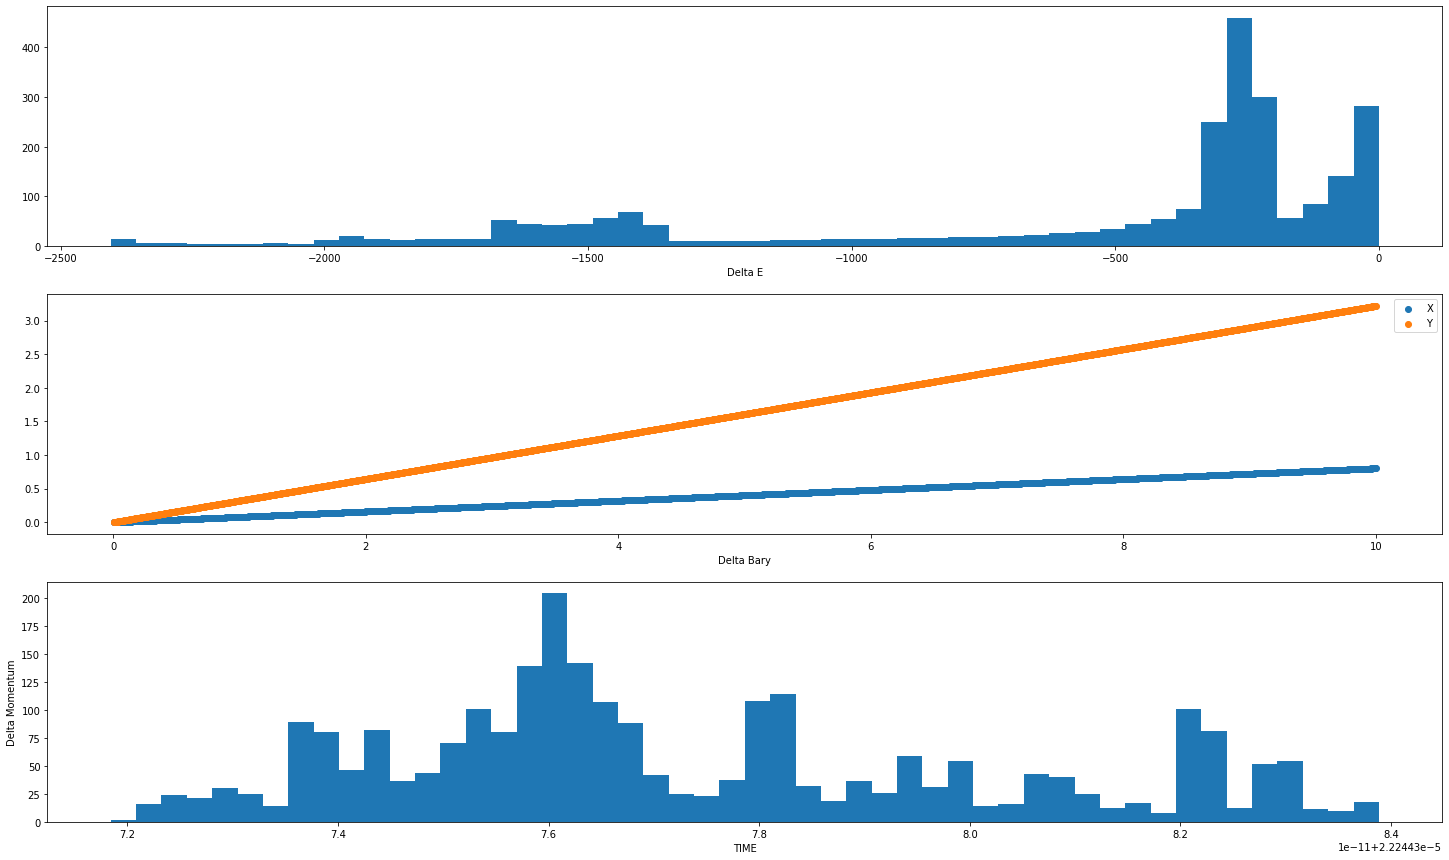

In [11]:
r.seed(1)
indexArray = np.array(sdf['eventID'])
indexArray = np.unique((indexArray/10000).astype(int))
index = np.random.choice(indexArray)*10000
print(index)
edf = sdf.loc[(sdf['eventID'] >= index) & (sdf['eventID'] <= (index+2560))]

# plot all events (sdf) or only 1 (edf)
# edf = sdf

plt.rcParams["figure.figsize"] = (25, 15)
fig = plt.figure()
gs = fig.add_gridspec(3, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2:,:])

# ENERGY PLOT
# ax1.hist((edf['e1']+edf['e2']+edf['e3'])-edf['iEnergy'], 50)
ax1.hist((edf['energy'])-edf['iEnergy'], 50)
ax1.set_xlabel('Delta E')
# ax1.set_xlabel('Time')
# ax.set_yscale('log')
# plt.set_xlim(0,10)

# BARY CENTER PLOT
ax2.scatter(edf['tEnd'], edf['baryDiffX'])
ax2.scatter(edf['tEnd'], edf['baryDiffY'])
ax2.set_xlabel('Delta Bary')
ax2.legend(("X","Y"),loc='best', ncol=1, fancybox=True)

# MOMENTUM PLOT
# ax3.hist(np.abs(edf['px']-edf['iPx']), 50)
ax3.hist(np.abs(edf['py']-edf['iPy']), 50)
ax3.set_ylabel('Delta Momentum')
ax3.set_xlabel('TIME')